In [1]:
!pip install pyspark
!pip install geopandas
!pip install contextily
!pip install mapclassify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 6.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=310391a6e99fc95501af16609bccfd9153183378f78bfea1b0bb6d0c8954ca69
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 95.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pk

In [2]:
from pyspark.sql import functions as fun
from pyspark.sql.types import *
import geopandas as gdp
from pyspark.sql import Window
from pyspark.sql.functions import avg, stddev
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)
import contextily as ctx
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [4]:
# Import the data
taxi_raw = spark.read.option("header", "true").csv("/content/trip_data_1.csv")
taxi_raw = taxi_raw.sample(fraction=0.05)
taxi_raw.cache()
taxi_raw.show(5, vertical=True)

-RECORD 0----------------------------------
 medallion          | 0BD7C8F5BA12B88E0... 
 hack_license       | 9FD8F69F0804BDB55... 
 vendor_id          | CMT                  
 rate_code          | 1                    
 store_and_fwd_flag | N                    
 pickup_datetime    | 2013-01-06 00:18:35  
 dropoff_datetime   | 2013-01-06 00:22:54  
 passenger_count    | 1                    
 trip_time_in_secs  | 259                  
 trip_distance      | 1.50                 
 pickup_longitude   | -74.006683           
 pickup_latitude    | 40.731781            
 dropoff_longitude  | -73.994499           
 dropoff_latitude   | 40.75066             
-RECORD 1----------------------------------
 medallion          | D8AADA4E722C87C10... 
 hack_license       | 8F1E4F779A4D67431... 
 vendor_id          | CMT                  
 rate_code          | 2                    
 store_and_fwd_flag | N                    
 pickup_datetime    | 2013-01-10 23:41:51  
 dropoff_datetime   | 2013-01-11

## Convert Timestamps and Invalid Records

We use the to_timestamp function that PySpark provides to convert DateTime strings into type "Timestamp". Additionally, we need to handle some invalid records. In our case, we drop null records and records where latitude and longitude records are zero.


In [6]:
# Convert pickup_datetime from string to type timestamp
taxi_raw = taxi_raw.withColumn('pickup_datetime',
                                fun.to_timestamp(fun.col('pickup_datetime'),
                                                "yyyy-MM-dd HH:mm:ss"))

# Convert dropoff_datetime from string to type timestamp
taxi_raw = taxi_raw.withColumn('dropoff_datetime',
                                fun.to_timestamp(fun.col('dropoff_datetime'),
                                                "yyyy-MM-dd HH:mm:ss"))

taxi_raw.sort(fun.col("pickup_datetime").desc()).show(3, vertical=True)

# get rid of records where geospatial and temporal columns are invalid
geospatial_temporal_colnames = ["pickup_longitude", "pickup_latitude", \
                                "dropoff_longitude", "dropoff_latitude", \
                                "pickup_datetime", "dropoff_datetime"]

taxi_raw = taxi_raw.na.drop(subset=geospatial_temporal_colnames)

# Import GeoJSON data and 
gdf = gdp.read_file("/content/nyc-boroughs.geojson")

-RECORD 0----------------------------------
 medallion          | 3A2D5A193BDA3F4B6... 
 hack_license       | E0047A489DC6CB334... 
 vendor_id          | CMT                  
 rate_code          | 1                    
 store_and_fwd_flag | N                    
 pickup_datetime    | 2013-01-20 19:55:28  
 dropoff_datetime   | 2013-01-20 20:02:23  
 passenger_count    | 2                    
 trip_time_in_secs  | 414                  
 trip_distance      | 1.40                 
 pickup_longitude   | -74.003838           
 pickup_latitude    | 40.737724            
 dropoff_longitude  | -74.004463           
 dropoff_latitude   | 40.724255            
-RECORD 1----------------------------------
 medallion          | 536D8342C2D0745CE... 
 hack_license       | CD24833414D55EED1... 
 vendor_id          | CMT                  
 rate_code          | 2                    
 store_and_fwd_flag | N                    
 pickup_datetime    | 2013-01-20 16:55:15  
 dropoff_datetime   | 2013-01-20

## Pandas

Here we use GeoPandas to calculate the area associated with each features geometry and store it as a new column

In [7]:
# To increase efficiency, we calculate the area associated with each feature's geometry and store it as a new column
gdf['area'] = gdf.apply(lambda x: x['geometry'].area, axis=1)

# Sort the features by the combination of borough code and the area of each feauture's geometry
gdf = gdf.sort_values(by=['boroughCode', 'area'], ascending=[True, False])

In [8]:
# create a dataframe to assign midpoints for plot labelling
taxi_data_nyc=pd.DataFrame()
taxi_data_nyc['name']=['Brooklyn','Bronx','Manhattan','Queens','Staten Island']
taxi_data_nyc['longitude']=[-8226965.777659751,	-8217245.359723684,-8231032.612616903 ,-8209876.454711132,-8264908.580818675]
taxi_data_nyc['latitude']=[4951617.166890504,4989379.312587755,4980655.755430193,4977252.668653602,4944238.06292613]  

## Plot the GeoJSON data based on the Manhattan GeoJSON file

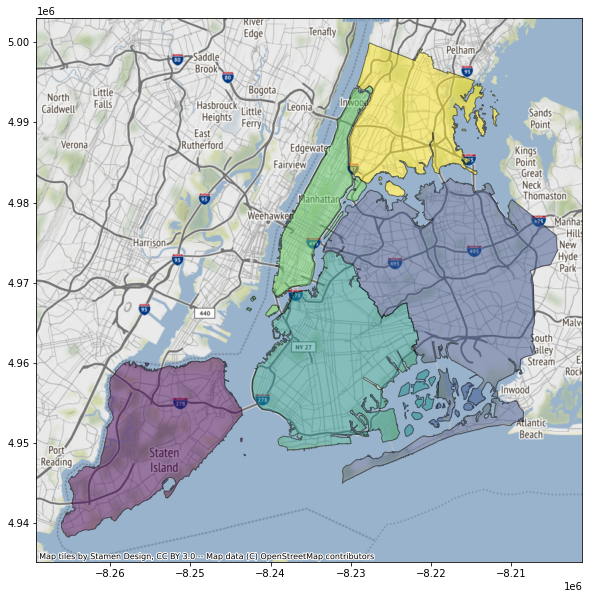

In [12]:
# Import GeoJSON data and create plot
gdf1 = gdp.read_file("/content/new-york-city-boroughs.geojson")
gdf1 = gdf1.to_crs(3857)
ax = gdf1.plot(column='cartodb_id',figsize=(10, 10), alpha=0.5, edgecolor='k' )
ctx.add_basemap(ax)

## Write a function that uses the features to find out which of the boroughs the trip ended


In [16]:
# # broadcast the features to the cluster and find which borough each trip ended
b_gdf = spark.sparkContext.broadcast(gdf)

def find_borough(latitude,longitude):
    mgdf = b_gdf.value.apply(lambda x: x['borough'] if \
                              x['geometry'].\
                              intersects(gdp.\
                                        points_from_xy(
                                            [longitude], \
                                            [latitude])[0]) \
                              else None, axis=1)
    idx = mgdf.first_valid_index()
    return mgdf.loc[idx] if idx is not None else None

find_borough_udf = fun.udf(find_borough, StringType())

In [18]:
df_with_boroughs = taxi_raw.\
                    withColumn("dropoff_borough", \
                              find_borough_udf(
                                fun.col("dropoff_latitude"),\
                                fun.col('dropoff_longitude')))
df_with_boroughs.cache()
df_with_boroughs.groupBy(fun.col("dropoff_borough")).count().show()

+---------------+-----+
|dropoff_borough|count|
+---------------+-----+
|         Queens|  674|
|           null|  316|
|       Brooklyn|  540|
|  Staten Island|    2|
|      Manhattan|11345|
|          Bronx|   68|
+---------------+-----+



In [19]:
# new_df = df_with_boroughs[['dropoff_borough','count']].copy()
new_df = df_with_boroughs.groupBy(fun.col("dropoff_borough")).count()
new_df = new_df.withColumnRenamed('dropoff_borough', 'name').toPandas()
gdf1 = gdf1.merge(new_df, on="name", how="left")

In [20]:
# gdf1  = gdf1.merge(taxi_data_nyc, on='name')
gdf.head()
# for i in range(len(gdf1)):  
  # print(gdf1.longitude[i],gdf1.latitude[i],gdf1.name[i],gdf1.count_dropoffs[i])

,boroughCode,borough,@id,geometry,area
72,1,Manhattan,http://nyc.pediacities.com/Resource/Borough/Ma...,"POLYGON ((-73.92641 40.87762, -73.92630 40.877...",0.005859
71,1,Manhattan,http://nyc.pediacities.com/Resource/Borough/Ma...,"POLYGON ((-73.92134 40.80085, -73.92031 40.799...",0.000233
51,1,Manhattan,http://nyc.pediacities.com/Resource/Borough/Ma...,"POLYGON ((-74.01675 40.69334, -74.01540 40.693...",0.000076
69,1,Manhattan,http://nyc.pediacities.com/Resource/Borough/Ma...,"POLYGON ((-73.94180 40.76905, -73.94286 40.768...",0.000062
73,1,Manhattan,http://nyc.pediacities.com/Resource/Borough/Ma...,"POLYGON ((-73.90665 40.87575, -73.90774 40.872...",0.000033


In [21]:
# Import GeoJSON data and 
gdf = gdp.read_file("/content/nyc-boroughs.geojson")

# To increase efficiency, we calculate the area associated with each feature's geometry and store it as a new column
gdf['area'] = gdf.apply(lambda x: x['geometry'].area, axis=1)

# Sort the features by the combination of borough code and the area of each feauture's geometry
gdf = gdf.sort_values(by=['boroughCode', 'area'], ascending=[True, False])

# broadcast the features to the cluster and find which borough each trip ended
b_gdf = spark.sparkContext.broadcast(gdf)

def find_borough(latitude,longitude):
    mgdf = b_gdf.value.apply(lambda x: x['borough'] if \
                              x['geometry'].\
                              intersects(gdp.\
                                        points_from_xy(
                                            [longitude], \
                                            [latitude])[0]) \
                              else None, axis=1)
    idx = mgdf.first_valid_index()
    return mgdf.loc[idx] if idx is not None else None

find_borough_udf = fun.udf(find_borough, StringType())

# Create table of trip drop-offs by borough
df_with_boroughs = taxi_raw.\
                    withColumn("dropoff_borough", \
                              find_borough_udf(
                                fun.col("dropoff_latitude"),\
                                fun.col('dropoff_longitude')))

df_with_boroughs.cache()
df_with_boroughs.groupBy(fun.col("dropoff_borough")).count().show()


window_spec = Window.partitionBy("dropoff_borough").\
    orderBy(fun.col("dropoff_borough"),
    fun.col("pickup_datetime"))

df_with_borough_durations = df_with_boroughs.\
    withColumn("trip_time_difference",\
    fun.col("pickup_datetime") - fun.lag(fun.col("dropoff_datetime"), 1).\
    over(window_spec))
df_with_borough_durations.show(50, vertical=True)

df_with_borough_durations = df_with_borough_durations.\
    withColumn("seconds", \
    fun.col("trip_time_difference").cast("long"))

df_with_borough_durations.show(50, vertical=True)

# And added this so speed later computations:
df_with_borough_durations.cache()

df_with_borough_durations.\
    selectExpr("floor(seconds / 3600) as hours").\
    groupBy("hours").\
    count().\
    sort("hours").\
    show()

df_with_borough_durations. \
    where("seconds > 0 AND seconds < 60*60*4"). \
    groupBy("dropoff_borough"). \
    agg(avg("seconds"), stddev("seconds")). \
    show()


+---------------+-----+
|dropoff_borough|count|
+---------------+-----+
|         Queens|  674|
|           null|  316|
|       Brooklyn|  540|
|  Staten Island|    2|
|      Manhattan|11345|
|          Bronx|   68|
+---------------+-----+

-RECORD 0------------------------------------
 medallion            | 1E26FB273E08FC0BE... 
 hack_license         | 88C76ADA068ED66B7... 
 vendor_id            | CMT                  
 rate_code            | 1                    
 store_and_fwd_flag   | N                    
 pickup_datetime      | 2013-01-02 20:12:40  
 dropoff_datetime     | 2013-01-02 20:18:02  
 passenger_count      | 1                    
 trip_time_in_secs    | 318                  
 trip_distance        | .70                  
 pickup_longitude     | 0                    
 pickup_latitude      | 0                    
 dropoff_longitude    | 0                    
 dropoff_latitude     | 0                    
 dropoff_borough      | null                 
 trip_time_difference |

In [22]:
new_df = df_with_borough_durations. \
    where("seconds > 0 AND seconds < 60*60*4"). \
    groupBy("dropoff_borough"). \
    agg(avg("seconds"))
new_df.show()

+---------------+------------------+
|dropoff_borough|      avg(seconds)|
+---------------+------------------+
|         Queens|432.72727272727275|
|           null| 595.5963302752293|
|       Brooklyn| 890.0526315789474|
|  Staten Island|            2280.0|
|      Manhattan|2551.2954545454545|
|          Bronx| 2095.135135135135|
+---------------+------------------+



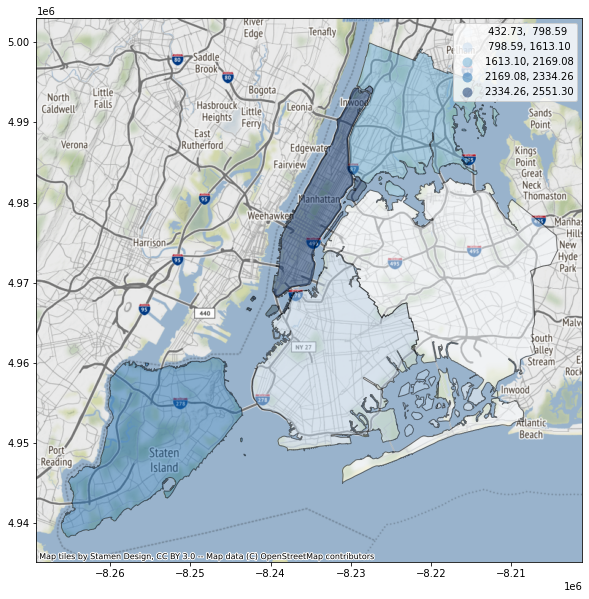

In [23]:
# Import GeoJSON data and 
gdf1 = gdp.read_file("/content/new-york-city-boroughs.geojson")
gdf1 = gdf1.to_crs(3857)
new_df = df_with_borough_durations. \
    where("seconds > 0 AND seconds < 60*60*4"). \
    groupBy("dropoff_borough"). \
    agg(avg("seconds"))
new_df = new_df.withColumnRenamed('dropoff_borough', 'name').\
                withColumnRenamed('avg(seconds)','waittime').toPandas()
gdf1 = gdf1.merge(new_df, on="name", how="left")
ax = gdf1.plot(column='waittime',figsize=(10, 10), alpha=0.5, edgecolor='k' ,cmap='Blues',legend=True,scheme="quantiles")
ctx.add_basemap(ax)